# Project 7: Quantum point contact in the external magnetic field

## 1. Introduction

The project focuses on the phenomenon where the confinement of electrons significantly influences the way they move in nanostructures. A notable example of this was first observed in a structure called 'Quantum Point Contact'. In this structure, electrons move through a very narrow path made by 'split gates'. In this project, we will study how an external magnetic field changes the movement properties of the electrons in the device under consideration.

We will be considering a system that corresponds to the QPC nanodevice built on the GaAs/AlGaAs interface with split gate architecture. Specifically, we will focus on the scenario where the magnetic field is directed perpendicular to the QPC nanodevice, along the z direction. To take into account the effects of the magnetic field, we include the so-called Peierls phase in the hopping energies, which modifies the hopping energy as follows:

\begin{equation}
t_{ij} = -t \exp\left(-i\frac{\phi}{2} (y_i + y_j)(x_i - x_h)\right)
\end{equation}
where $\phi = \frac{2\pi Be}{h} \cdot 10^{-18}$ and $x_i, x_j, y_i, y_j$ are the coordinates expressed in nanometers. $t = \frac{\hbar^2}{2ma^2}$ is the standard hopping energy, which results from the discretization of the Schrödinger equation on our lattice.

In this project, we aim to analyze the effects of the external magnetic field on the electron transport properties of the QPC nanodevice by considering the impact of the Peierls phase on the hopping energies.

Below we provide a figure of a QPC nanodevice in external magnetic field

<center><img src="QPC.png" width="500">

## 2. Model and results

In [2]:
# Import necessary libraries
import numpy as np
import kwant
from matplotlib import pyplot as plt
import scipy.linalg as la
from scipy.constants import physical_constants
from ipywidgets import interact

In [3]:
# Define physical constants
h_bar = physical_constants['Planck constant over 2 pi'][0]   
m_el = physical_constants['electron mass'][0]         
eV_unit = physical_constants['electron volt'][0]             
el_charge = physical_constants['elementary charge'][0]    
hh = physical_constants['Planck constant'][0]  


In [4]:
# Define model parameters
a=10  # Lattice constant
m_eff=0.067  # Effective mass
e_diel=13.1  # Dielectric constant
t=h_bar**2/(2*m_el*m_eff*(a*1e-9)**2)/eV_unit  # Hopping energy
W=40  # Width
L=60  # Length

In [5]:
# Define gate parameters
top1=70*a
top2=10*a
bottom1= 30*a
bottom2= -30*a
left=20*a
right=40*a
d=6*a

In [14]:
def g(u,v):
    R=np.sqrt(u**2+v**2+d**2)
    return np.arctan2(u*v,R*d)/(2*np.pi)

# Define the top gate voltage function
def top_gate(x,y,U):
    l,r,t,b=left,right,top1,bottom1
    return U*(g(x-l,y-b)+g(x-l,t-y)+g(r-x,y-b)+g(r-x,t-y))/e_diel

# Define the bottom gate voltage function
def bottom_gate(x,y,U):
    l,r,t,b=left,right,top2,bottom2
    return U*(g(x-l,y-b)+g(x-l,t-y)+g(r-x,y-b)+g(r-x,t-y))/e_diel

# Define the total potential
def V_pot(site,U):
    x,y = site.pos
    return 4*t+top_gate(x,y,U)+bottom_gate(x,y,U)

In [13]:
# Define the magnetic field-dependent hopping function
def hopping(site_0, site_1, B):
    x0, y0 = site_0.pos
    x1, y1 = site_1.pos
    C = 2*np.pi*B*el_charge*10**(-18)/hh
    return -t*np.exp( -0.5j * C * (y0+y1) * (x0-x1) )

In [15]:
# Define the system shape
def shape(pos):
    x,y = pos
    return x >= 0 and x <= L*a and y >= 0 and y <= W*a


In [16]:
# Initialize the system
sys = kwant.Builder()
lat = kwant.lattice.square(a, norbs=1)
sys[lat.shape(shape,(0,0))] = V_pot
sys[lat.neighbors()] = hopping

# Initialize the left lead
leadl = kwant.Builder(kwant.TranslationalSymmetry((-a,0)))
leadl[lat.shape(shape, (0,0))] = V_pot
leadl[lat.neighbors()] = hopping

# Initialize the right lead
leadr = leadl.reversed()

# Attach the leads
sys.attach_lead(leadl)
sys.attach_lead(leadr)

# Finalize the system
sysf = sys.finalized()

In [17]:
# Define a function to calculate transmission using the kwant module.
def calc_transmission(syst, ene, B,U):
    smatrix = kwant.smatrix(syst, ene, params=dict(B=B,U=U))
    return smatrix.transmission(0, 1)

In [18]:
# Generate a list of 100 points between 0.5 and 1.5
Utab=np.linspace(0.5,1.5, 100)
Ttab=np.zeros(100)

# Fermi energy is set to 0.014
E_F = 0.014

'100%'

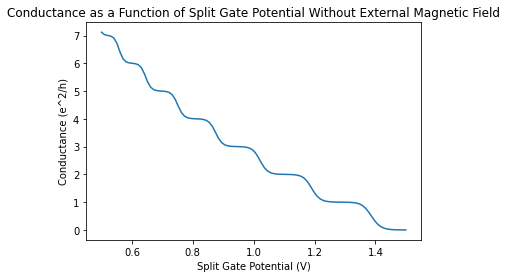

In [23]:
from IPython.display import display, clear_output

def cls():
    os.system('cls' if os.name=='nt' else 'clear')
    
# For each point in Utab, compute the transmission and save it in Ttab
for i in range(0,100):
     Ttab[i]=calc_transmission(sysf,E_F,0,Utab[i])
     clear_output()
     display(str(i+1)+"%")
    
# Plot the conductance as a function of split gate potential without external magnetic field.
plt.title('Conductance as a Function of Split Gate Potential Without External Magnetic Field')
plt.xlabel('Split Gate Potential (V)')
plt.ylabel('Conductance (e^2/h)')
plt.plot(Utab,Ttab)
plt.show()

The code calculates and displays a graph of conductance as a function of split gate potential when there's no external magnetic field. This graph show a step-like shape, reflecting conductance quantization.

Quantization of conductance is related to the quantum nature of electrons flowing through a narrow area in a conductor. Here's why it happens:

__Quantized States:__ In a narrow area, an electron can only have certain energy levels. Each energy level can carry a specific amount of current. When the Fermi energy goes past another energy level, there's an extra "step" in conductance.

__Subband Models:__ In a tight space, an electron can only move in certain "modes" or "subbands." Each of these can carry one unit of quantum conductance, leading to the step-like shape in the conductance graph.

__Pauli Exclusion Principle:__ This principle means that each energy level can only be filled by at most one electron with spin up and one with spin down. When an energy level is filled, the next electron has to go to a higher energy level, leading to another "step" in conductance.

__No Scattering:__ In perfect conditions, with no scattering off impurities or defects, all available states are fully conducting. Each filled quantum state adds to the conductance, leading to the step-like shape.

In [25]:
# Define a function to plot the conductance for different values of magnetic field
def plot1(B,number):
    for i in range(0,100):
        Ttab[i]=calc_transmission(sysf,E_F,B,Utab[i])
        clear_output()
        display("Plot "+str(number+1)+":"+str(i+1)+"%")

    plt.plot(Utab,Ttab)

'Plot 5:100%'

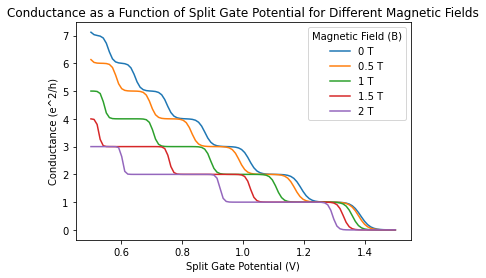

In [28]:
# List of magnetic fields for which the conductance will be plotted
Btab=[0,0.5,1,1.5,2]

# Plot the conductance for each magnetic field in Btab
for j in range(len(Btab)):
    plot1(Btab[j],j)
    
# Label the plot
plt.title('Conductance as a Function of Split Gate Potential for Different Magnetic Fields')
plt.xlabel('Split Gate Potential (V)')
plt.ylabel('Conductance (e^2/h)')
plt.legend([f'{b} T' for b in Btab], title="Magnetic Field (B)")
plt.show()


The code calculates and displays graphs of conductance as a function of split gate potential for different values of an external magnetic field.

The magnetic field has a significant effect on the conductance in the system. This influence mainly stems from two phenomena:

__Aharonov-Bohm Effect:__ An external magnetic field can cause a change in the phase of an electron's wave function, known as the Aharonov-Bohm effect. This quantum effect can lead to notable changes in conductance when the magnetic field is strong enough.

__Landau Levels:__ In a magnetic field, the states of electrons in space are quantized into what are called Landau levels. Each of these levels can conduct a unit of quantum conductance. As the magnetic field increases, the Landau levels become more energetically separated, leading to changes in the step-like structure of conductance.

Each line on the graph represents conductance at a different magnetic field. You can see that increasing the magnetic field leads to a shift in the steps to the right, consistent with predictions related to Landau levels. Additionally, increasing the magnetic field may lead to an increase in the "width" of the steps, which might be associated with the blurring of Landau levels due to the Aharonov-Bohm effect.

In summary, the external magnetic field can significantly impact the conductance in the system, leading to substantial changes in the step-like structure of the conductance graph. These effects arise from fundamental quantum phenomena such as the Aharonov-Bohm effect and Landau levels.


'100%'

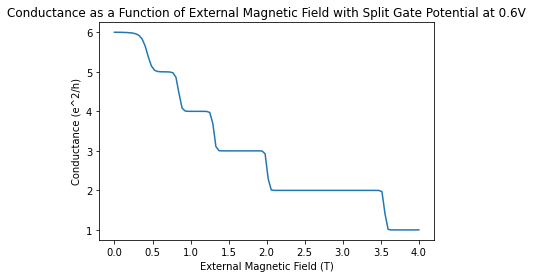

In [29]:
# Generate a list of 100 points between 0 and 4
Btab=np.linspace(0,4, 100)
Ttab=np.zeros(100)

# For each magnetic field in Btab, compute the transmission at a fixed gate potential and save it in Ttab
for i in range(0,100):
    Ttab[i]=calc_transmission(sysf,E_F,Btab[i],0.6)
    clear_output()
    display(str(i+1)+"%")
    
# Plot the conductance as a function of external magnetic field with split gate potential at 0.6V.
plt.title('Conductance as a Function of External Magnetic Field with Split Gate Potential at 0.6V')
plt.xlabel('External Magnetic Field (T)')
plt.ylabel('Conductance (e^2/h)')
plt.plot(Btab,Ttab)
plt.show()

The results shown on the graph represent the conductance as a function of an external magnetic field with a fixed split gate potential at 0.6V.

Analyzing and interpreting the results may lead to the following conclusions:

__Step-Like Structure:__ The graph may show a distinctive step-like structure, which reflects the quantization of conductance. Each "step" on the plot corresponds to reaching another Landau level, which can conduct a unit of quantum conductance.

__Landau Levels Phenomenon:__ In a magnetic field, the states of electrons are quantized into what are called Landau levels. Increasing the magnetic field leads to greater energy separation of these levels, which can result in a more pronounced step-like shape.

__Influence of Split Gate Potential:__ Setting the split gate potential at 0.6V affects the energy structure of the system, which may also influence the shape of the plot. This influence may be related to the geometry of the system and electrostatic interactions.

In summary, the graph of conductance as a function of the external magnetic field with a set split gate potential shows a complex structure that reflects quantum phenomena, such as the quantization of Landau levels.

In [35]:
# Import the fixed function from ipywidgets
from ipywidgets import fixed

# Define a function to plot the probability density and current for a given magnetic field and fixed gate potential
def plot_density_current(B=0, U=0.6):
    energy = 0.014  # Fermi energy is 0.014
    params = {'U': U, 'B': B}
    
    # Compute the wave functions
    wave_functions = kwant.wave_function(sysf, energy, params=params)(0)
    
    # Define the current operator
    J_operator = kwant.operator.Current(sysf)
    
    
    # Compute the density and current
    density = np.sum(np.abs(wave_functions)**2, axis=0)
    current = np.sum([J_operator(psi, params=params) for psi in wave_functions], axis=0)

    # Plot the probability density
    plt.figure(figsize=(10, 5))
    kwant.plotter.map(sysf, density, cmap='inferno', show=False)
    plt.title('Probability Density for B = {} T'.format(B))
    
    # Plot the probability current
    kwant.plotter.current(sysf, current, cmap='inferno', show=False)
    plt.title('Probability Current for B = {} T'.format(B))
    plt.show()
    
# Create an interactive plot of the probability density and current
interact(plot_density_current, B=(-10, 10, 0.1), U=fixed(0.6))

interactive(children=(FloatSlider(value=0.0, description='B', max=10.0, min=-10.0), Output()), _dom_classes=('…

<function __main__.plot_density_current(B=0, U=0.6)>

The code shown above is used to examine how the obtained maps of probability density and probability current change as the magnetic field is increased, for both positive and negative values.

By using the interact function from the widgets module, you can dynamically analyze these changes. Here are a few key insights that can be drawn from the analysis:

__Probability Density:__ The probability density map shows where the electron is most likely located in the system. Introducing a magnetic field can lead to noticeable changes in the density layout, reflecting changes in the structure of quantum states.

__Probability Current:__ The probability current map shows how the likelihood of electrons flowing through the system changes depending on the magnetic field. Introducing a magnetic field can lead to complex flow patterns of current, which is related to effects like the Aharonov-Bohm effect.

In summary, the code provides an interactive way to understand how magnetic fields influence the quantum properties of the system, including where electrons are likely to be found and how they are likely to move. These insights are essential for understanding and designing new quantum devices and materials.

In [31]:
# Import the cm module from matplotlib
from matplotlib import cm

# Generate two lists of 100 points between 0 and 7, and 0.5 and 1.5, respectively
Btab=np.linspace(0,7, 100)
Utab=np.linspace(0.5,1.5, 100)
TTab=np.zeros((100,100))

# For each pair of magnetic field and gate potential, compute the transmission and save it in TTab
for j in range(0,100):
    for i in range(0,100):
        TTab[j][i]=calc_transmission(sysf,E_F,Btab[j],Utab[i])
        if i==0:
            clear_output()
            display(str(j+1)+"%")

'100%'

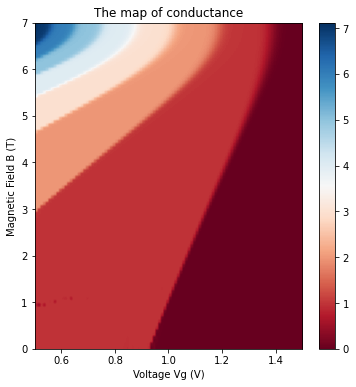

In [32]:
# Find the minimum and maximum of Btab and Utab
Bmin, Bmax = Btab[0], Btab[-1]
Umin, Umax = Utab[0], Utab[-1]

# Plot the map of conductance
plt.figure(figsize = (6 ,6))
plt.imshow(TTab , extent =[Umin , Umax , Bmin , Bmax ],aspect='auto',cmap=cm.RdBu)
plt.colorbar ();
plt.title('The map of conductance')
plt.xlabel('Voltage Vg (V)')
plt.ylabel('Magnetic Field B (T)')
plt.show()

__*Conduction Map:*__

__Density Area:__ This map can show areas with different shades, which reflect how conductance gets quantized. Bright areas might mean that the conductance is high, and dark areas where it is low.

__Magnetic Field and Voltage Dependence:__ You can see that the conduction structure changes with the magnetic field and gate voltage. These changes come from the subtle quantum things happening in the narrow QPC channel.


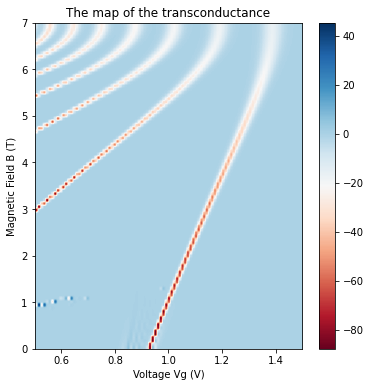

In [33]:
# Compute the derivative of TTab along the gate potential axis
differ = np.diff(TTab, n=1, axis=1)
dV = Utab[1] - Utab[0]
differ = differ / dV

# Plot the map of the transconductance
plt.figure(figsize=(6, 6))
plt.imshow(differ, extent=[Umin, Umax, Bmin, Bmax], aspect='auto', cmap=cm.RdBu)
plt.colorbar()
plt.title('The map of the transconductance')
plt.xlabel('Voltage Vg (V)')
plt.ylabel('Magnetic Field B (T)')
plt.show()

__*Transconductance Map:*__

__Peaks:__ On this map, you might see standout peaks, which match up to energy states created inside the QPC's narrow channel. These peaks can be seen as showing the quantum states that are tied to particular energies.

__Magnetic Field Dependence:__ As the magnetic field goes up, you can notice changes in the structure of these peaks, reflecting how the magnetic field affects the energy structure of the setup.

__Effect of Gate Voltage:__ The gate voltage can also change how transconductance is spread out, affecting the energy barrier in the tight channel.

## Conclusions

The code provides an analysis and visualisation of conductance and transconductance in a tight Quantum Point Contact (QPC) channel as a function of external magnetic field and gate voltage. Various properties and relationships are examined.

The code represents a complex analysis of a tight Quantum Point Contact (QPC) channel, a key component in the field of quantum electronics. Through various visualisation and calculation methods, the code enables an understanding of how the external magnetic field and gate voltage influence the energy structure and conductance in the tight QPC channel.
